In [1]:
# import celloracle as co
# co.check_python_requirements()

In [3]:
# import 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import warnings
import random

np.random.seed(42069)
random.seed(42069)

warnings.filterwarnings('ignore')

### Question 1
We will use pyscn to estimate the success of engineered cardiomyocytes.

In [4]:
import pySingleCellNet as pySCN
sc.set_figure_params(dpi = 160 )

In [5]:
# read in adata, subsampled
adata = sc.read_h5ad('direct_conversion_data_subsampled/direct_conversion_subsampled_5k.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 5000 × 33595
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
def preprocess_pipeline(mydata, exclude_high_ribo = True, ribo_thresh = 35, exclude_high_mt = True, 
                        mt_thresh = 3, exclude_doublets = True, doublet_thresh = 98, exclude_sporad_genes = True, gThresh = 5,
                        exclude_bad_genes = True):
        
    if exclude_high_ribo:
        # remove high ribo expressing cells
        mydata.var['ribo'] = mydata.var_names.str.startswith(("Rps","Rpl"))
        sc.pp.calculate_qc_metrics(mydata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
        mydata = mydata[mydata.obs['pct_counts_ribo'] < ribo_thresh, :]
        
    if exclude_high_mt:
        # remove high mt expressing cells 
        mydata.var['mt']= mydata.var_names.str.startswith(("mt-"))
        sc.pp.calculate_qc_metrics(mydata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        mydata = mydata[mydata.obs['pct_counts_mt'] < mt_thresh, :]
        
    if exclude_doublets:
        # remove doublets using 10x rec'd thresh
        thresh = np.percentile(mydata.obs['total_counts'], doublet_thresh)
        mydata = mydata[mydata.obs['total_counts'] < thresh, :]
        
    if exclude_sporad_genes:
        # remove bad genes that are expressed in less than 5 cells
        sc.pp.filter_genes(mydata, min_cells=gThresh)
        
    if exclude_bad_genes:
        # get mt, ribo genes and Malat1 for removal
        mito_genes = mydata.var_names.str.startswith('mt-')
        ribo_genes = mydata.var_names.str.startswith(("Rpl","Rps"))
        malat_gene = mydata.var_names.str.startswith("Malat1")

        # remove em
        remove = np.add(mito_genes, ribo_genes)
        remove = np.add(remove, malat_gene)

        keep = np.invert(remove)

        # remove these BAD genes
        mydata = mydata[:,keep].copy()
        
    
    
    return mydata

In [13]:
adata = preprocess_pipeline(adata, exclude_high_ribo = True, ribo_thresh = 15, exclude_high_mt = True, 
                        mt_thresh = 0.5, exclude_doublets = True, doublet_thresh = 95, exclude_sporad_genes = True, gThresh = 0,
                        exclude_bad_genes = True)

In [17]:
# read in the reference adata/training data
adTrain= sc.read_h5ad('TM_FACS_heart.h5ad')

In [18]:
# adTrain.var['mt']= adTrain.var_names.str.startswith(("mt-"))
# adTrain.var['ribo'] = adTrain.var_names.str.startswith(("Rps","Rpl"))
# sc.pp.calculate_qc_metrics(adTrain, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)
# axs = sc.pl.violin(adTrain, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

In [19]:
adTrain = preprocess_pipeline(adTrain, exclude_high_ribo = True, ribo_thresh = 8, exclude_high_mt = False, 
                        mt_thresh = 0.5, exclude_doublets = True, doublet_thresh = 95, exclude_sporad_genes = True, gThresh = 0,
                        exclude_bad_genes = True)

In [20]:
# lets see how many genes are shared between our training data and query data
genesTrain = adTrain.var_names
genesQuery = adata.var_names

# let's see how many genes overlap
cgenes = genesTrain.intersection(genesQuery)
len(cgenes)
# 19424 shared genes

19327

In [21]:
# keep only the shared genes in the train data
adTrain1 = adTrain[:,cgenes]

In [22]:
# get n_genes_by_counts for our query datta
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [23]:
# check that all cells have more than 500 genes
print(len(adata.obs), len(adata.obs[adata.obs['n_genes_by_counts'] >= 500] ))

# 4718 cells out for 5000 

4483 4483


In [24]:
# keep only shared genes in our query data
adQuery = adata[:,cgenes].copy()

# subset for the cells that have greater than 500 genes  
adQuery = adQuery[adQuery.obs["n_genes_by_counts"]>=500,:].copy()
adQuery

AnnData object with n_obs × n_vars = 4483 × 19327
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'mt', 'n_cells'
    uns: 'batch_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [25]:
adTrain1

View of AnnData object with n_obs × n_vars = 4113 × 19327
    obs: 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cluster.ids', 'mouse.id', 'mouse.sex', 'plate.barcode', 'subtissue', 'tissue', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

Both our query and train datas have the same geens now. The query data only contains cells with more than 500 genes as well.

In [26]:
adTrain1.obs['cell_ontology_class'].value_counts()

fibroblast             1981
endothelial cell       1153
leukocyte               469
myofibroblast cell      172
endocardial cell        165
cardiac muscle cell     133
smooth muscle cell       40
Name: cell_ontology_class, dtype: int64

In [27]:
# split reference data intro train and held out data
expTrain, expVal = pySCN.splitCommonAnnData(adTrain1, ncells=150, dLevel="cell_ontology_class")

leukocyte : 
469
smooth muscle cell : 
40
cardiac muscle cell : 
133
endocardial cell : 
165
myofibroblast cell : 
172
endothelial cell : 
1153
fibroblast : 
1981


In [28]:
# train the classifier 
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0, nTrees = 1000 ,nTopGenePairs = 100, 
                                           dLevel = "cell_ontology_class", stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  731  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 692 top gene pairs

Finished pair transforming the data



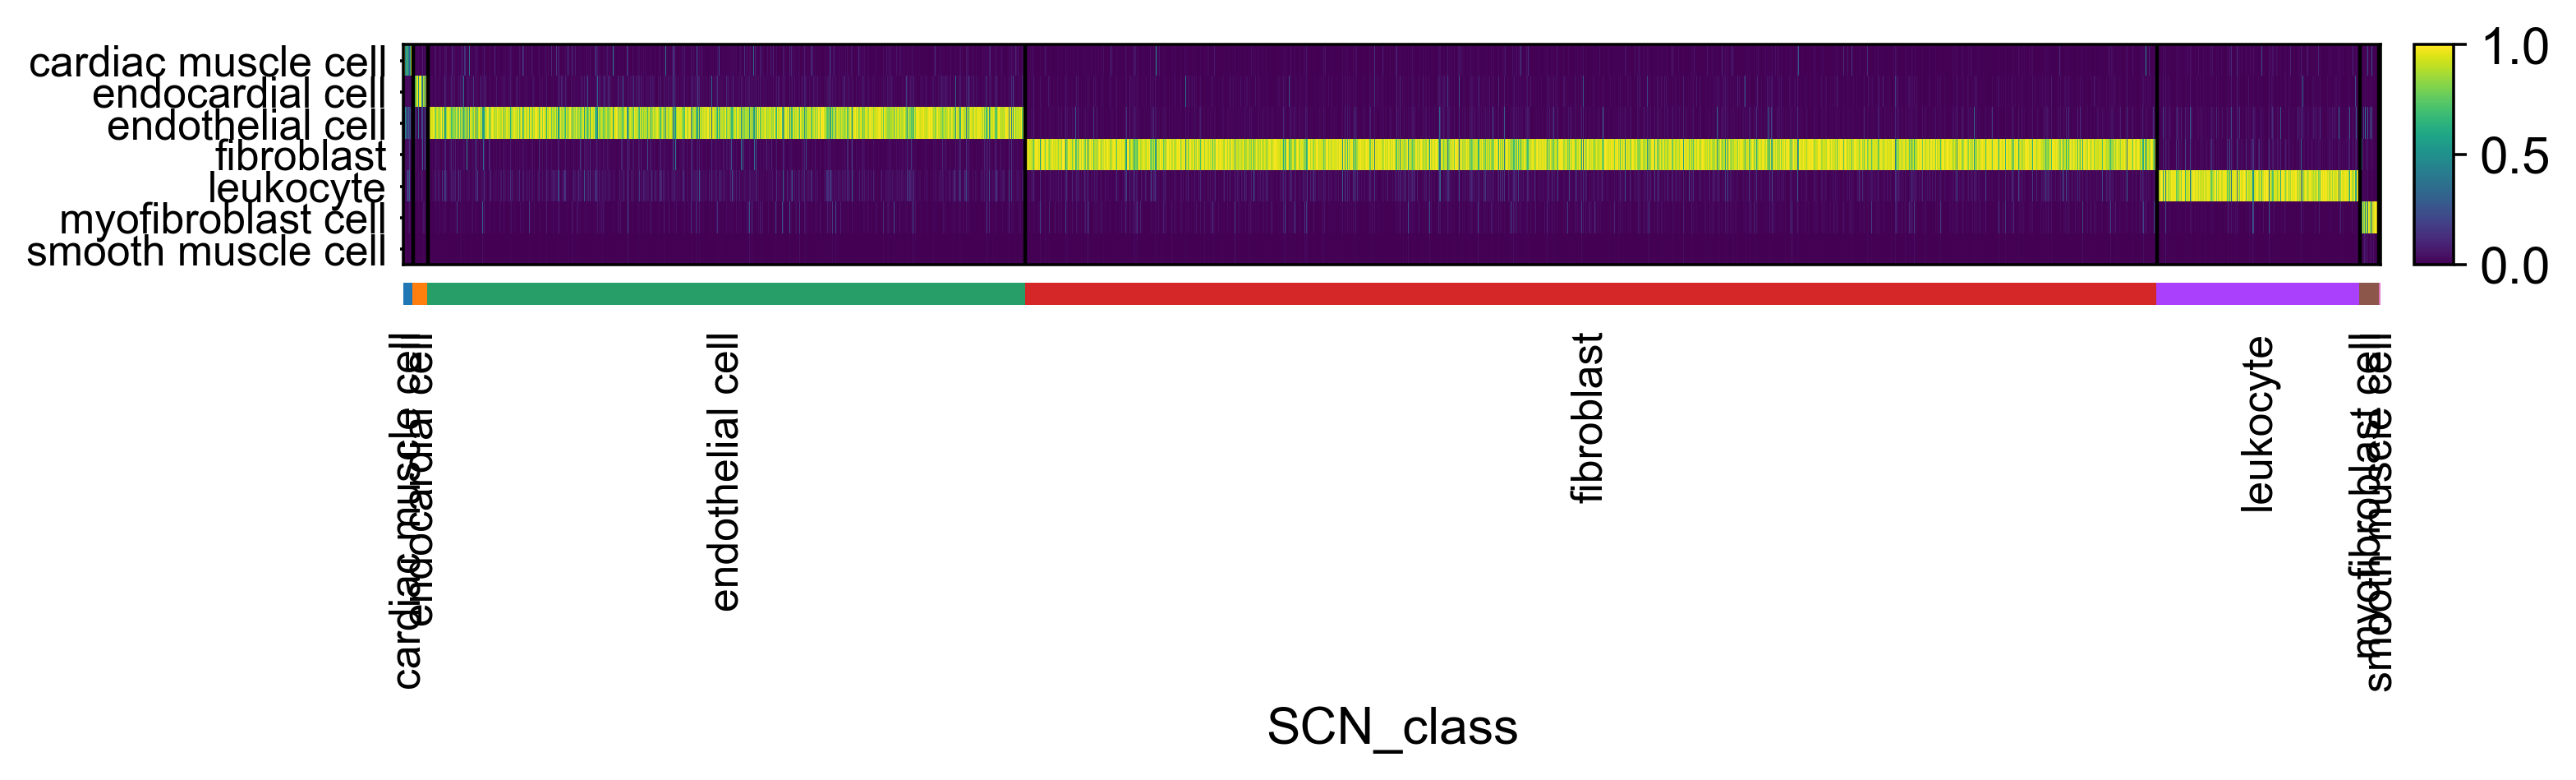

In [29]:
# classify held out data and visualize 
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)

# plot grouped by predicted cell label aka the cell_ontology_class with the highest probability 
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

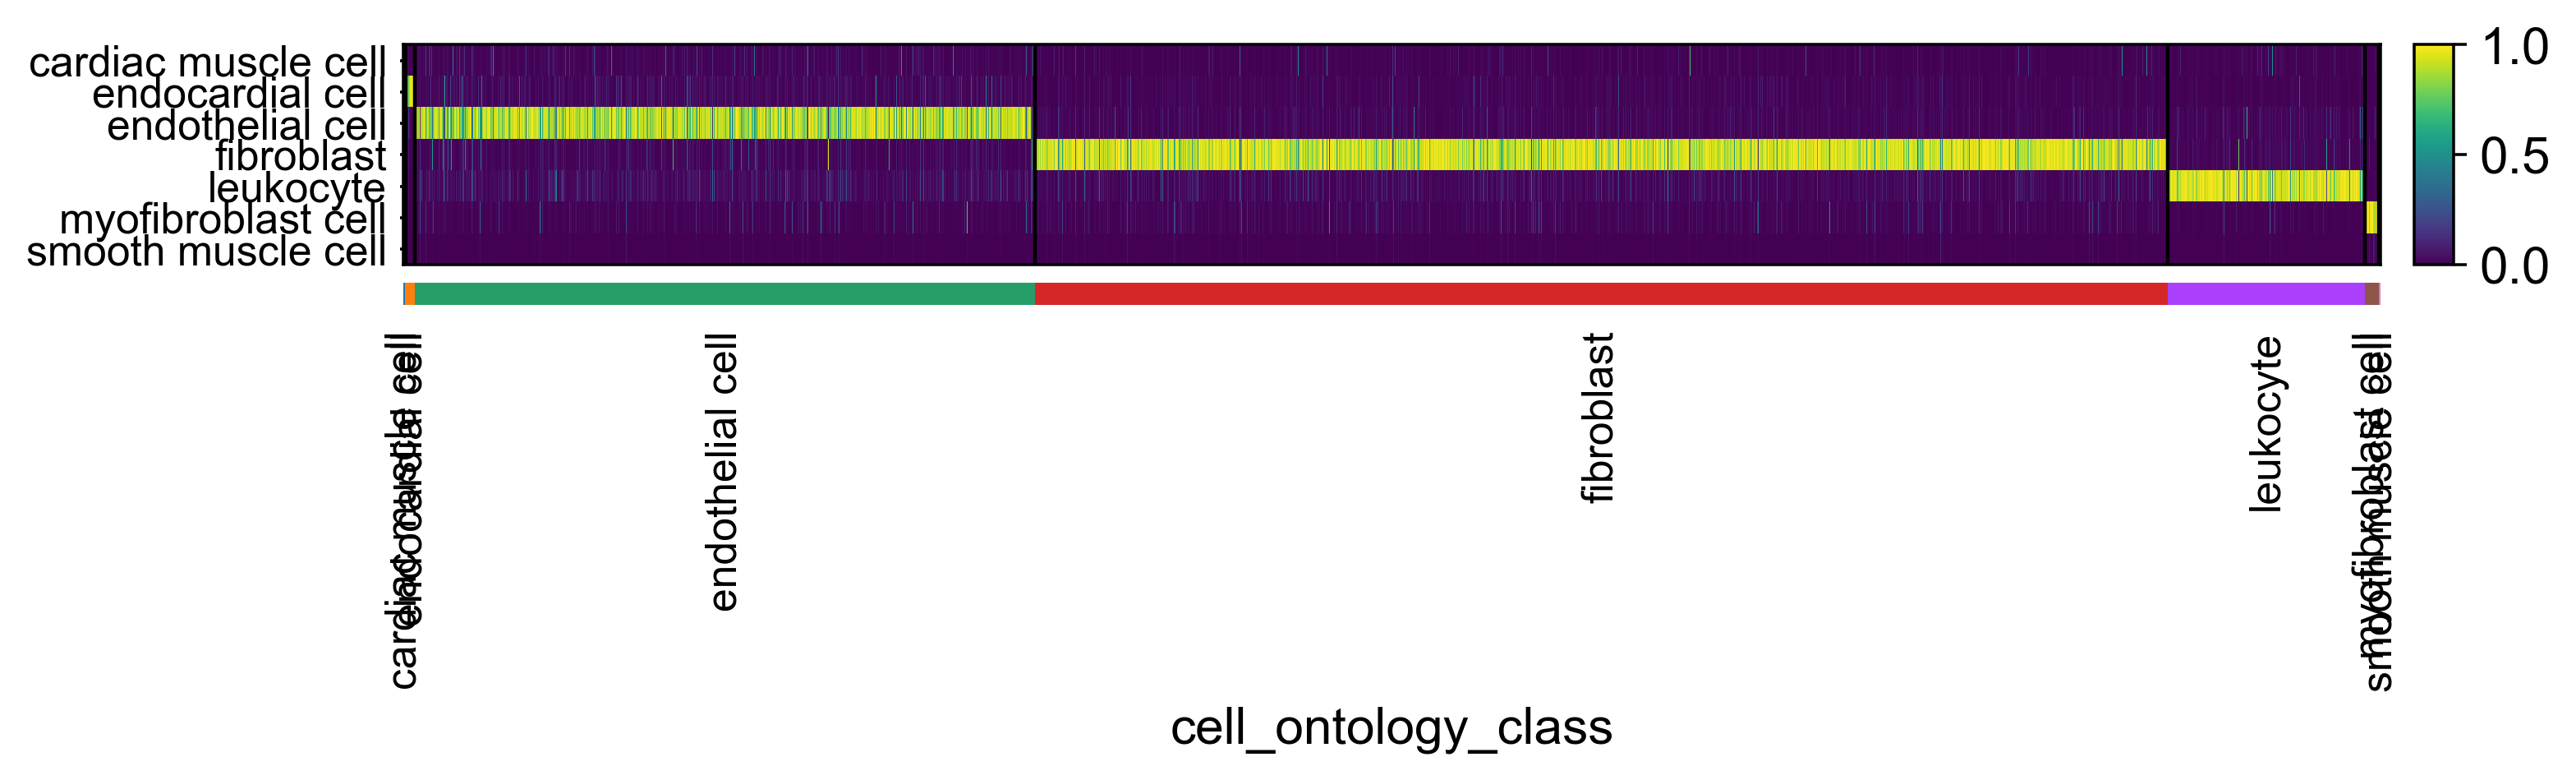

In [30]:
# y axis is cell types in the classifier, x axis is true cell labels
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='cell_ontology_class', cmap='viridis', dendrogram=False, swap_axes=True)

# looks pretty accurate

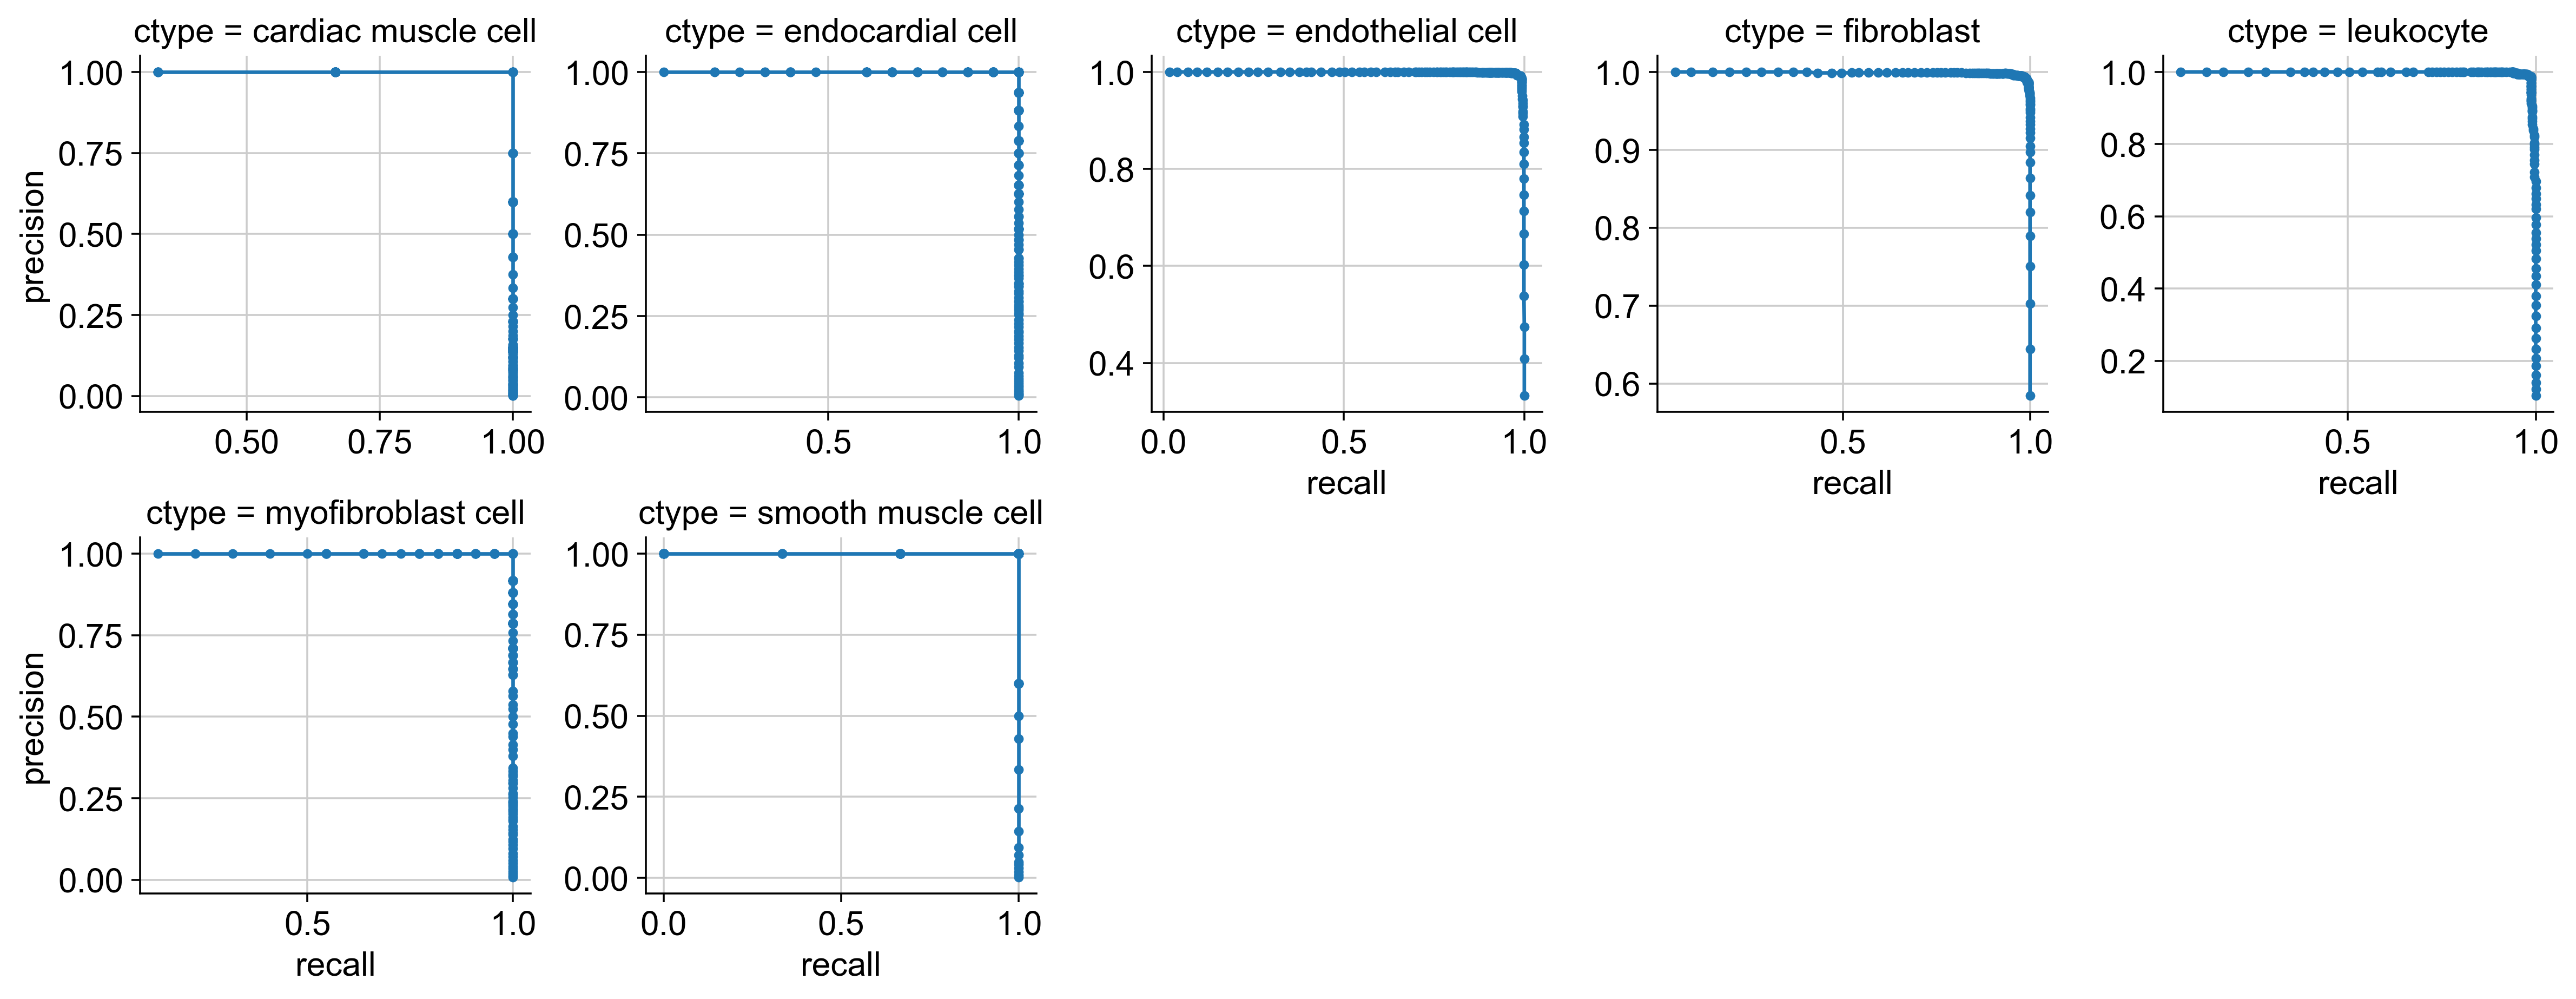

In [31]:
# determine how well classifier predicts cell types of held out data and visualize 
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", 
                                classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")
pySCN.plot_PRs(assessment)
plt.show()

# figure out params to improve cardiac muscle cell precision 

In [32]:
# print accuracy 
print('Accuracy:', assessment['accuracy'])

Accuracy: 0.9815394242803505


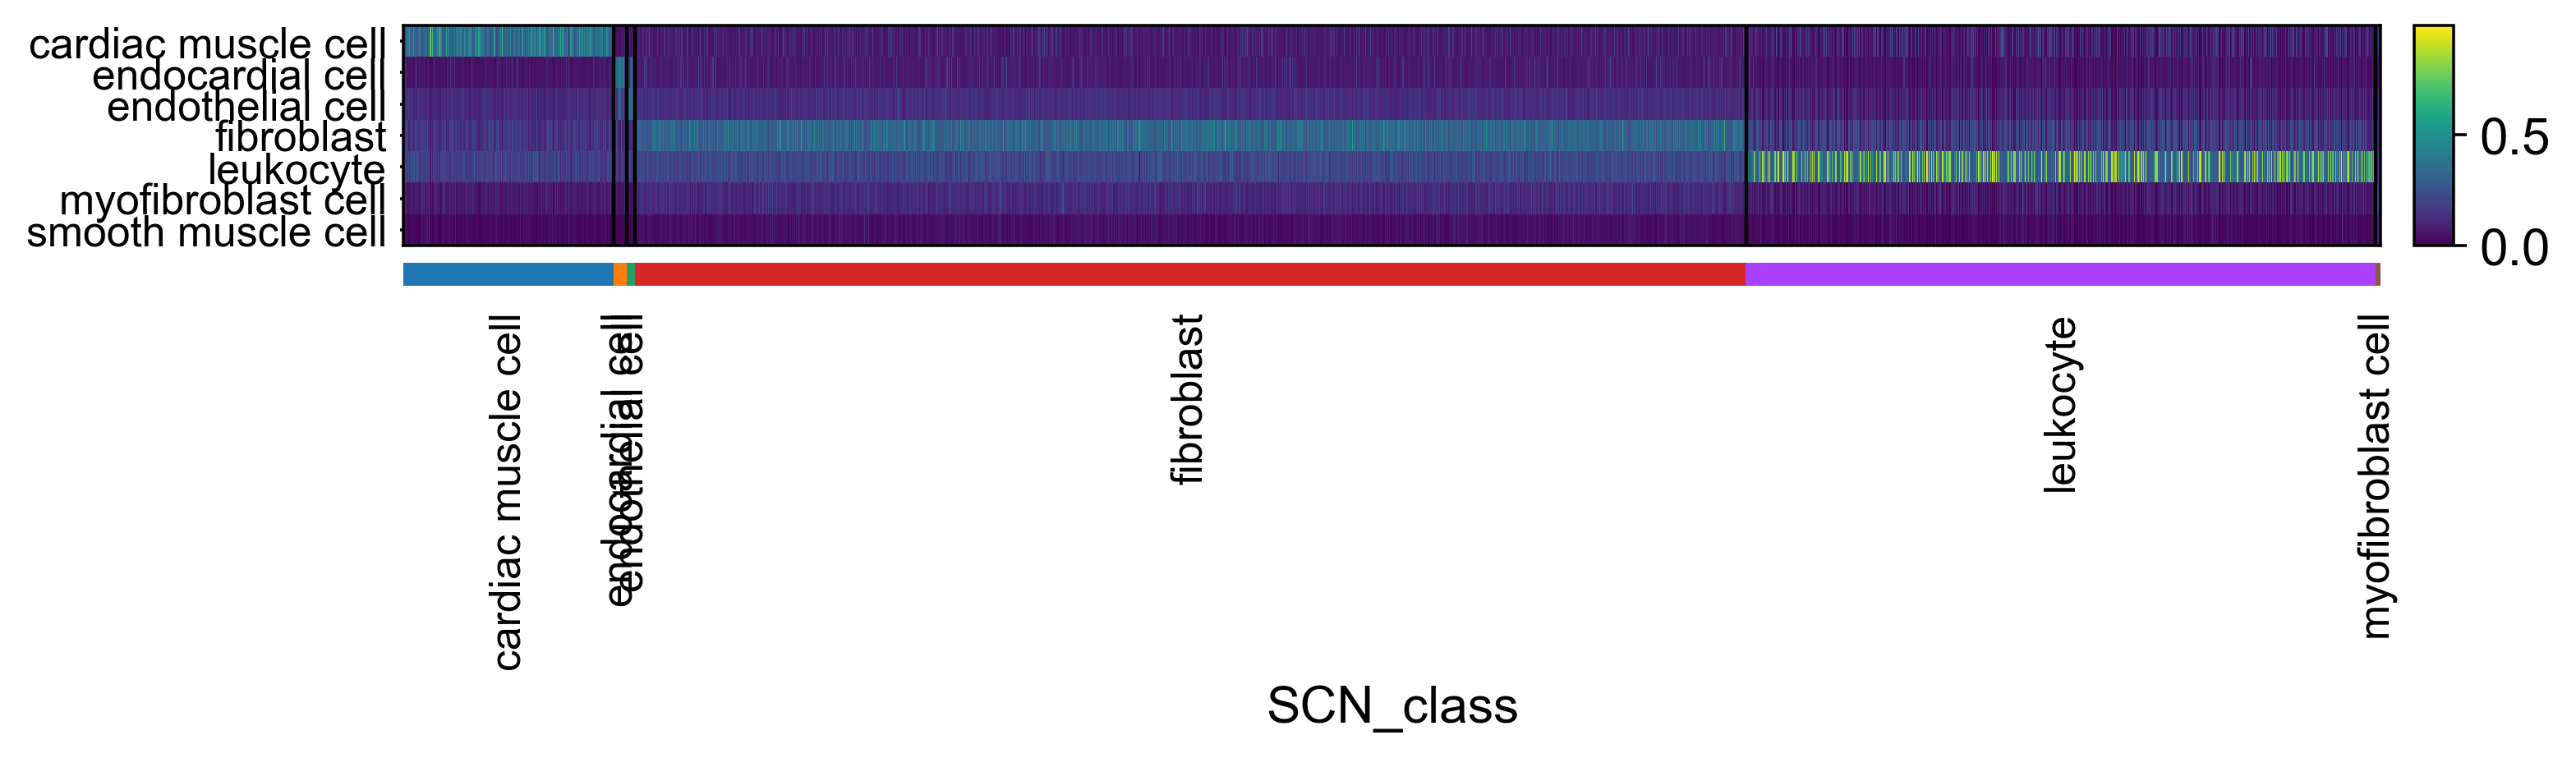

In [33]:
# classifiy independent query data
adQ = pySCN.scn_classify(adQuery, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adQ, adQ.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

In [34]:
# predicted cell types for query data
adQ.obs['SCN_class']

CGTTCTGTCATGCAAC-6    cardiac muscle cell
TGAGCATGTCAGCTAT-5              leukocyte
ATTGGTGGTGAGTGAC-2              leukocyte
AACCATGGTACAAGTA-4             fibroblast
GATCTAGAGATGCGAC-1             fibroblast
                             ...         
GCAGCCACATTGGTAC-4    cardiac muscle cell
CATTCGCAGATCCTGT-3             fibroblast
CATCGGGGTCTCATCC-4             fibroblast
GTTCTCGAGAGAACAG-4             fibroblast
GACTAACCATCGGTTA-3             fibroblast
Name: SCN_class, Length: 4483, dtype: category
Categories (6, object): ['cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell']

In [35]:
# how many of each predicited type 
# cardiac muscle cell + fibroblast
adQ.obs['SCN_class'].value_counts()

fibroblast             2519
leukocyte              1428
cardiac muscle cell     477
endocardial cell         29
endothelial cell         19
myofibroblast cell       11
Name: SCN_class, dtype: int64

### Doesn't looks like the differentiation ran well?

### Question 2
How mature are your engineered cadriomyocytes?

In [36]:
# import the perinatal reference set
adRef = sc.read_h5ad('perinatal_reference_data/Kannan_perinatal_reference.h5ad')

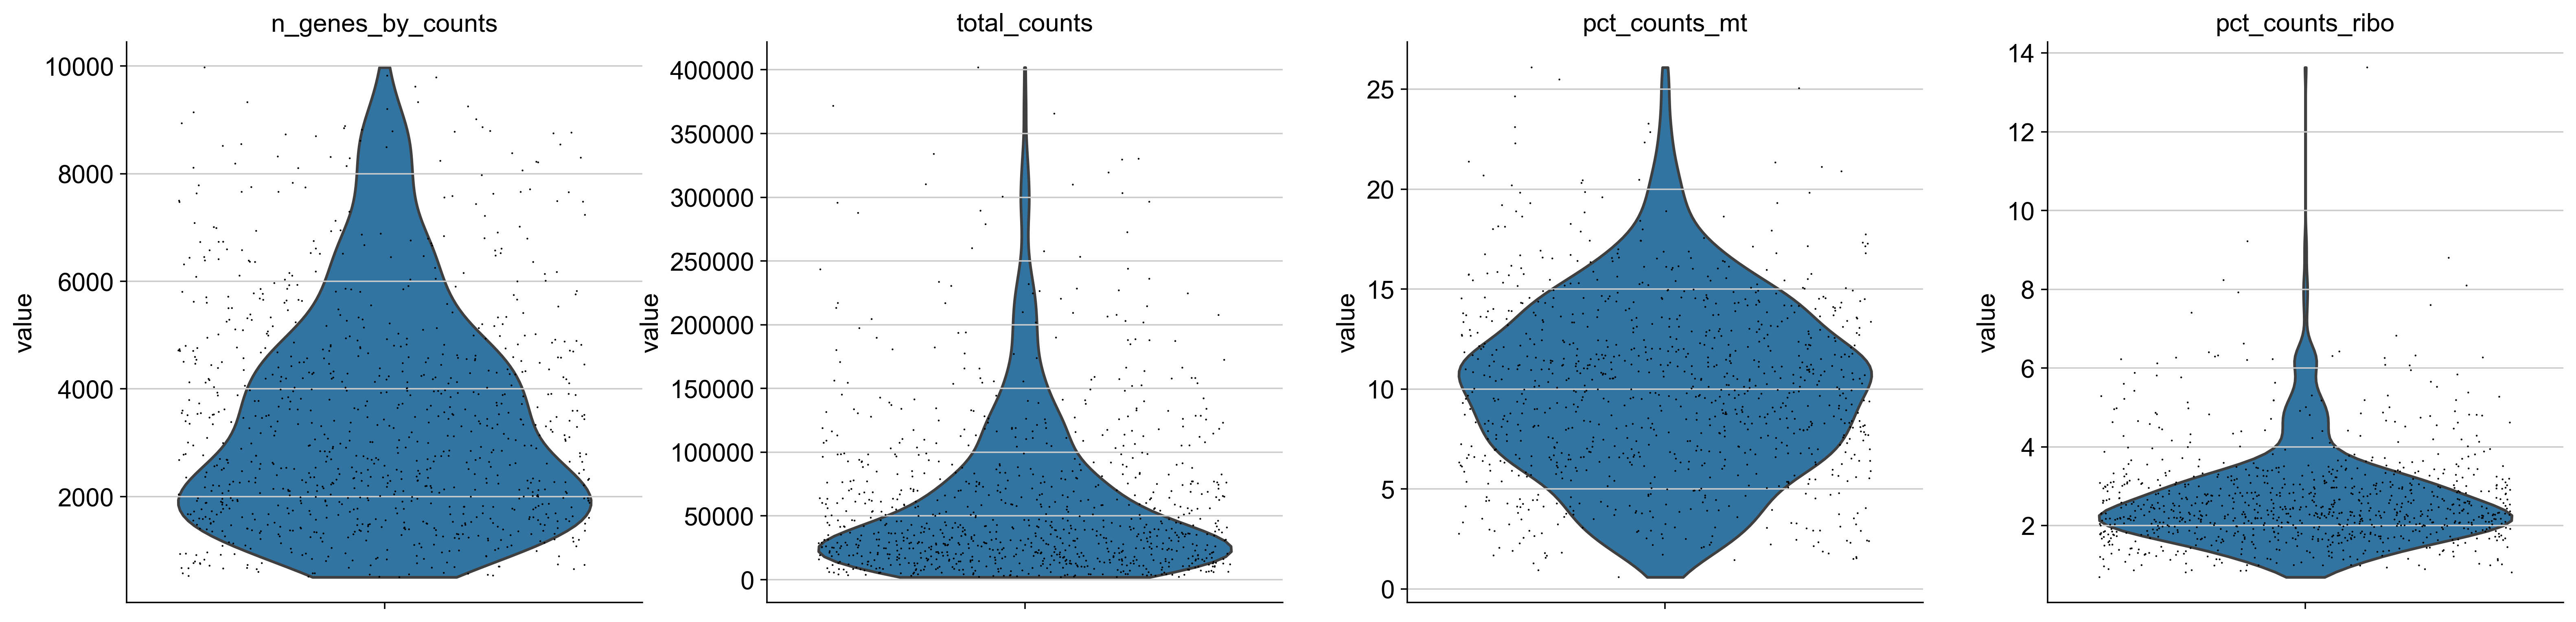

In [37]:
# id ribo and mt genes and score
adRef.var['mt']   = adRef.var_names.str.startswith(("mt-"))
adRef.var['ribo'] = adRef.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adRef, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)
axs = sc.pl.violin(adRef, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

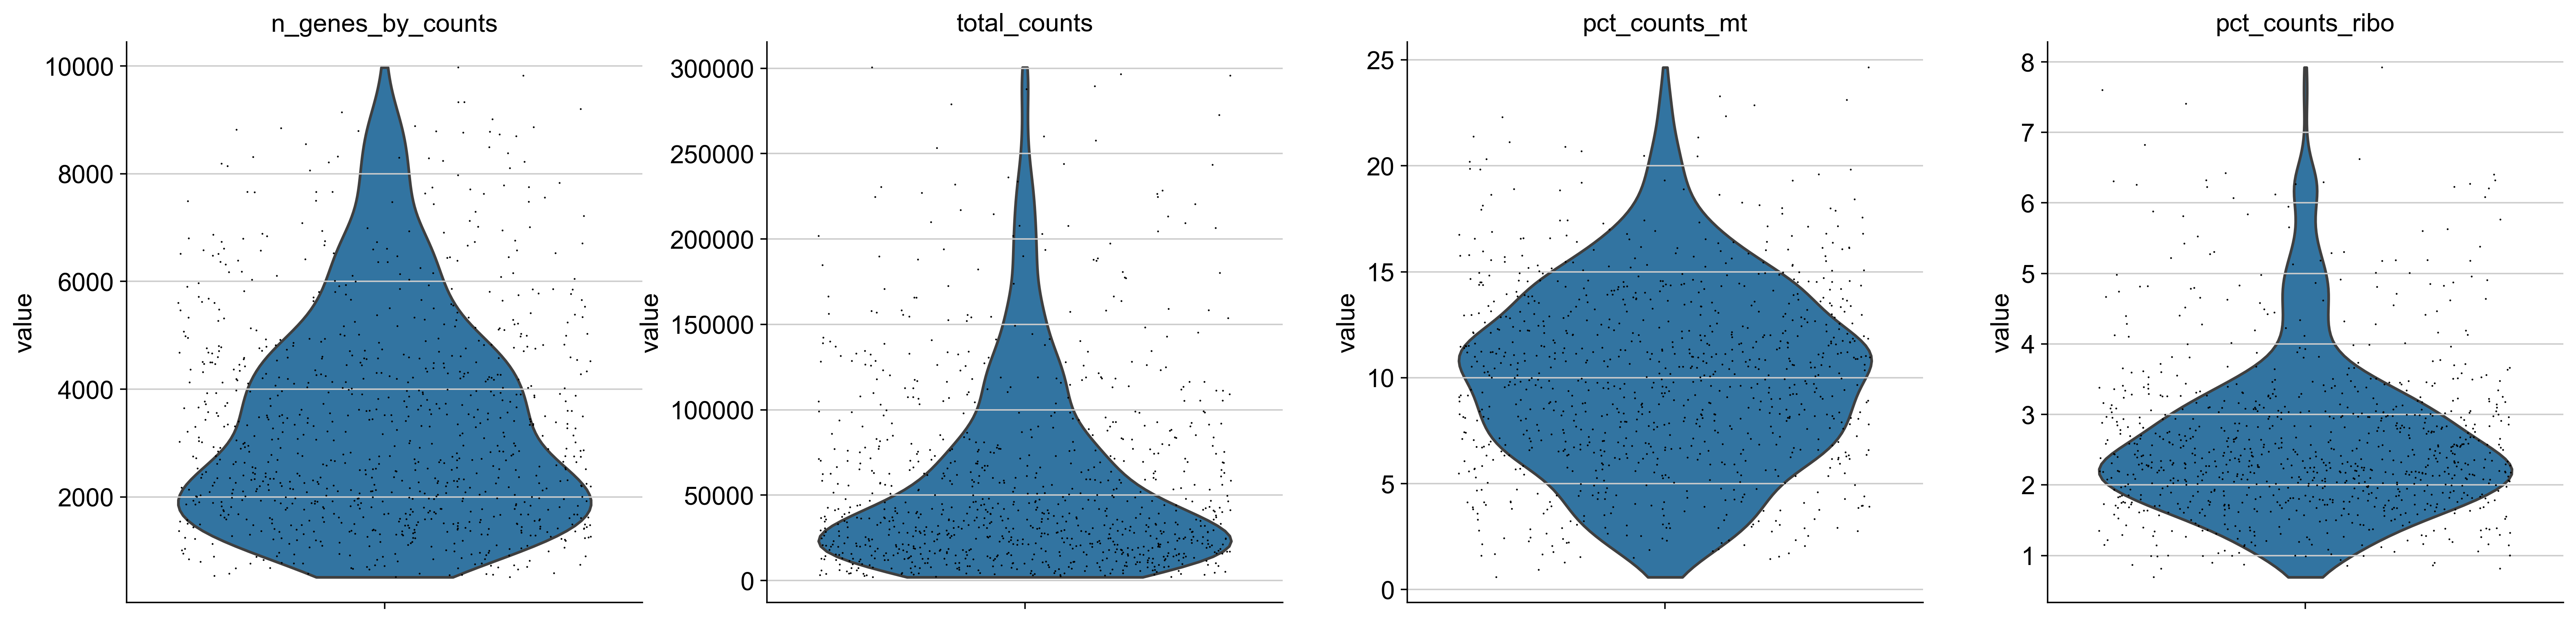

In [38]:
# remove bad cells, slightly different ribo threshold based on above violin plots, still 2% for doublets based off 10x rec
thresh = np.percentile(adRef.obs['total_counts'], 99)
adRef = adRef[adRef.obs['total_counts'] < thresh, :]
adRef = adRef[adRef.obs['pct_counts_mt'] < 25, :]
adRef = adRef[adRef.obs['pct_counts_ribo'] < 8, :]
axs = sc.pl.violin(adRef, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

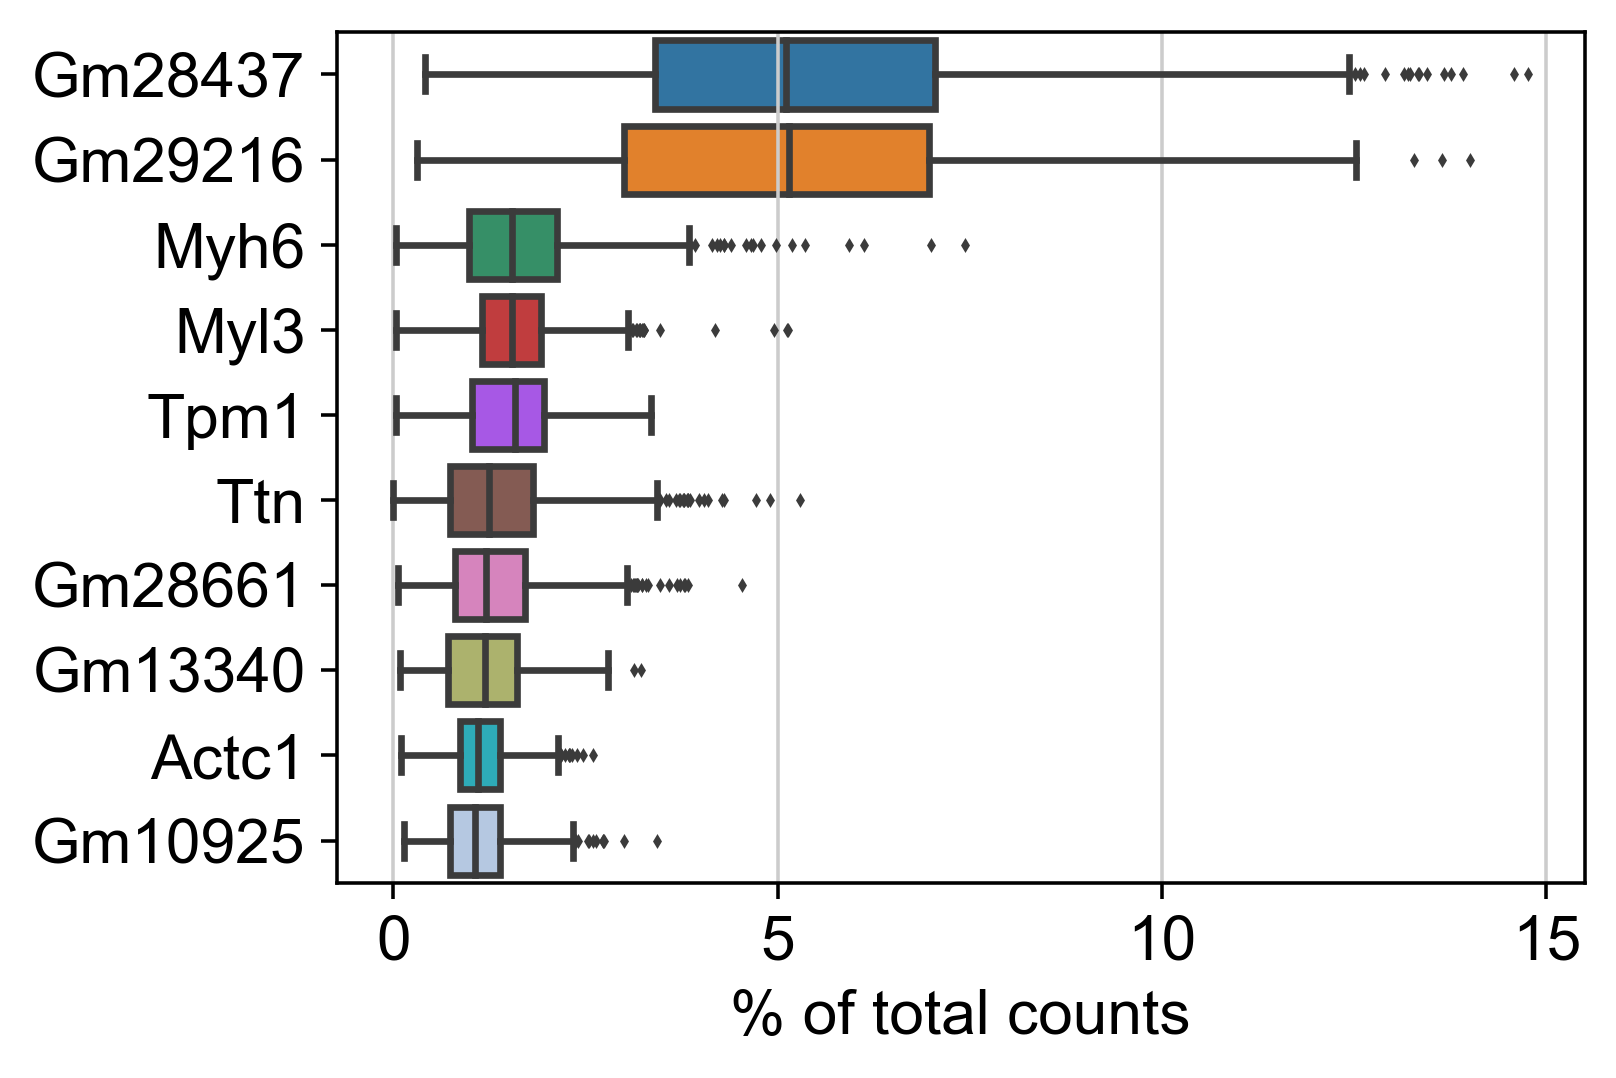

In [39]:
mito_genes = adRef.var_names.str.startswith("mt-")
ribo_genes = adRef.var_names.str.startswith(("Rpl", "Rps"))
malat_gene = adRef.var_names.str.startswith("Malat1")

adRef.var['mt'] = mito_genes
adRef.var['ribo'] = ribo_genes

adRef = adRef[:, np.invert(mito_genes | ribo_genes | malat_gene)]
sc.pl.highest_expr_genes(adRef, n_top=10)

<AxesSubplot:xlabel='n_cells_by_counts'>

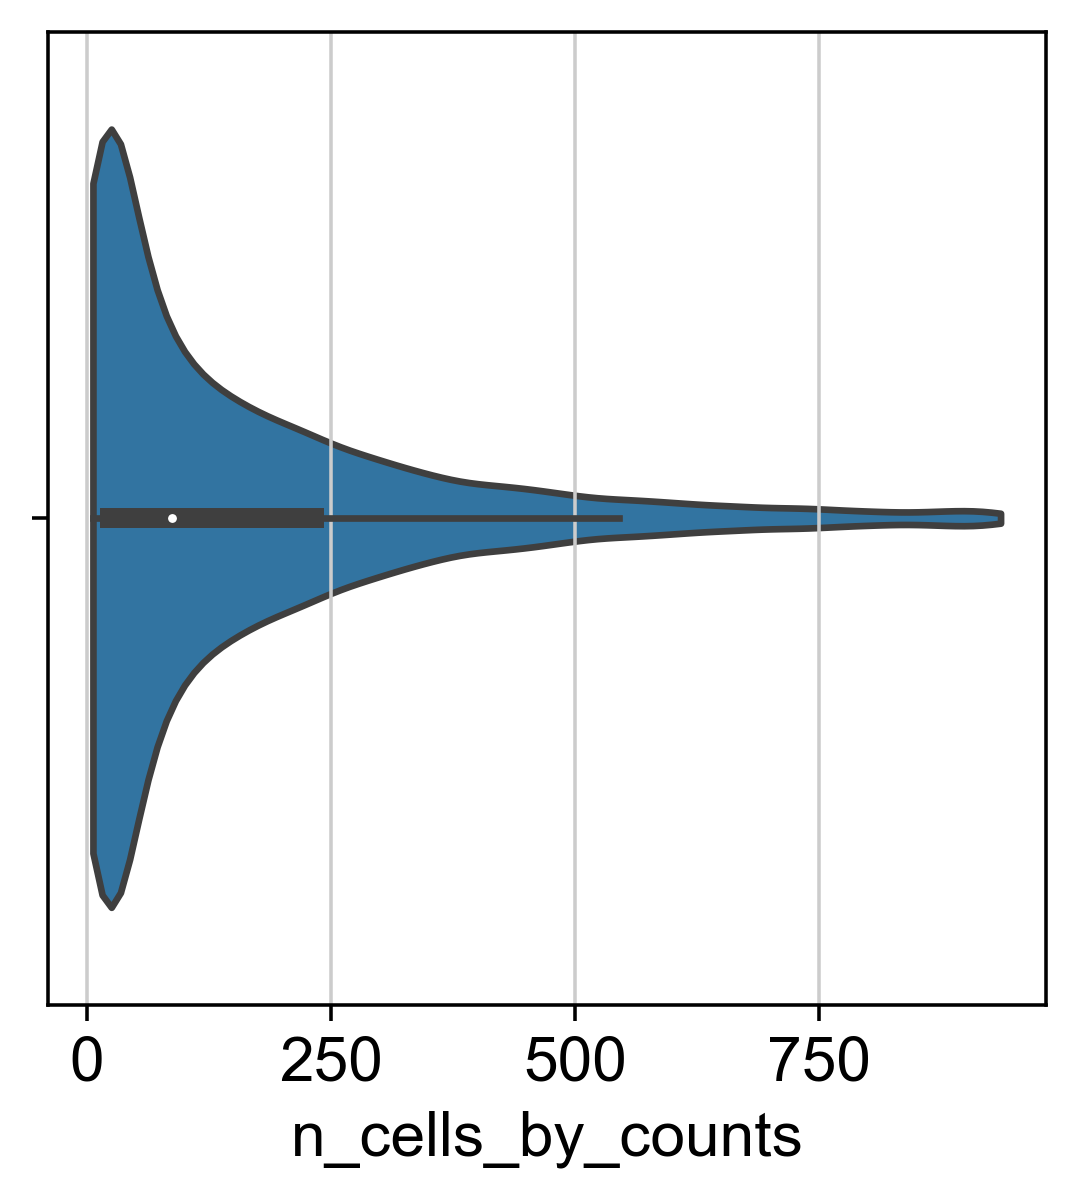

In [40]:
adRef = adRef[:,adRef.var['n_cells_by_counts'] > 5]
sns.violinplot(adRef.var['n_cells_by_counts'], cut=0)

In [41]:
def shannonEntropy(preprocessedMydata):
    """
    TODO
    """
    GeneMeanExpr = np.mean(preprocessedMydata.X, axis=0)
    Top1000Gene  = np.argsort(GeneMeanExpr)[-1000:]
    Subset       = preprocessedMydata[:, Top1000Gene]
    Subset.X      += 1e-5
    Proportion   = Subset.X / np.sum(Subset.X, axis=1)[:, np.newaxis]
    EntropyScore = -np.sum(Proportion * np.log2(Proportion), axis=1)
    return EntropyScore


In [42]:
  refEntropyScore = shannonEntropy(adRef)
queryEntropyScore = shannonEntropy(adQuery[adQ.obs['SCN_class'] == 'cardiac muscle cell'])

In [43]:
refPlot = pd.DataFrame(refEntropyScore, columns=["Score"])
refPlot['timepoint'] = list(refSubset.obs['timepoint'])
refPlotSorted = refPlot.sort_values(by='timepoint')

plt.figure(figsize=(5, 3))
sns.boxplot(data=refPlotSorted, x='timepoint', 
            y='Score', 
            order=['e14', 'e18', 'p0', 'p4', 'p8', 
                   'p11', 'p14', 'p18', 'p22', 'p35', 'p56'])

NameError: name 'refSubset' is not defined

In [136]:
queryEntropyScore

ArrayView([9.606552 , 9.624956 , 9.633112 , 9.529236 , 9.584942 ,
           9.728182 , 9.656227 , 9.675388 , 9.338379 , 9.613173 ,
           9.683157 , 9.717226 , 9.572933 , 9.702221 , 9.604515 ,
           9.520824 , 9.606513 , 9.392003 , 9.745488 , 9.594674 ,
           9.413341 , 9.706677 , 9.692705 , 9.614233 , 9.612428 ,
           9.559675 , 9.655068 , 9.64279  , 9.509451 , 9.693998 ,
           9.440282 , 9.694527 , 9.374916 , 9.407839 , 9.623671 ,
           9.512781 , 9.546005 , 9.694924 , 9.348383 , 9.452811 ,
           9.5940895, 9.46219  , 9.349499 , 9.618118 , 9.648987 ,
           9.600134 , 9.659071 , 9.692196 , 9.68965  , 9.508055 ,
           9.5683155, 9.607285 , 9.609488 , 9.680507 , 9.440385 ,
           9.422204 , 9.318449 , 9.583081 , 9.586843 , 9.626652 ,
           9.468709 , 9.43131  , 9.62779  , 9.612781 , 9.493869 ,
           9.71472  , 9.712223 , 9.195555 , 9.636017 , 9.648378 ,
           9.610179 , 9.402687 , 9.142357 , 9.632999 , 9.547682 ,
          

In [143]:
adQuery.X

(4718, 15895)

In [141]:
adQuery = adQuery[adQuery.obs["n_genes_by_counts"]>=500,:].copy()
adata = adata[:,adata.var['n_cells_by_counts'] > 5]
sns.violinplot(adata.var['n_cells_by_counts'], cut=0)

array([[0.43701002, 0.05401   , 0.14801   , ..., 0.11601   , 0.07301   ,
        0.03101   ],
       [0.123     , 0.122     , 0.093     , ..., 0.35      , 0.146     ,
        0.025     ],
       [0.069     , 0.07      , 0.123     , ..., 0.191     , 0.146     ,
        0.033     ],
       ...,
       [0.069     , 0.076     , 0.157     , ..., 0.151     , 0.062     ,
        0.026     ],
       [0.044     , 0.089     , 0.172     , ..., 0.107     , 0.136     ,
        0.041     ],
       [0.058     , 0.142     , 0.135     , ..., 0.107     , 0.204     ,
        0.039     ]], dtype=float32)

In [ ]:
refGeneMeanExpr = np.mean(adRef.X, axis=0)
refTop1000Gene  = np.argsort(refGeneMeanExpr)[-1000:]
refSubset       = adRef[:, refTop1000Gene]
refSubset.X      += 1e-5
refProportion   = refSubset.X / np.sum(refSubset.X, axis=1)[:, np.newaxis]
refEntropyScore = -np.sum(refProportion * np.log2(refProportion), axis=1)